# Warning
### This project examines hateful, offensive, toxic language on Reddit
### and exposes language that is degrading and disturbing.

In [1]:
# notes for rerunning:

# df read at the beginning of each major section - make sure location/name is consistent
# writes df at the end of comment, submission-selftext, and submissions-title sections 
# (before examination of)
# comment was commented out so new df was not created

# Reddit Comments Classification

In order to predict class labels for the comments we collected from Reddit, we chose to base our classifier on the Twitter classifier made public by Davidson et al., which was used in their research for the automatic hate-speech detection of Twitter posts. 

Beginning with the initial dataset of Twitter posts compiled by Davidson et al., which were labeled through crowd-sourcing as hate speech (0), offensive speech (1) or neither hate speech nor offensive speech (2), we extract features from the Twitter posts and train a logistic regression model to predict the class label of the posts.

We then apply the same feature extraction techniques to our dataset consisting of Reddit comments, along with the logistic regression model to predict class labels for our own data.

The complete Davidson et al. dataset can be found at https://github.com/t-davidson/hate-speech-and-offensive-language.

Davidson, Thomas et al. 2017. Automated Hate Speech Detection and the Problem of Offensive Language. Proceedings of the Eleventh International AAAI Conference on Web and Social Media. In ICWSM, 512-515.

@inproceedings{hateoffensive,
  title = {Automated Hate Speech Detection and the Problem of Offensive Language},
  author = {Davidson, Thomas and Warmsley, Dana and Macy, Michael and Weber, Ingmar}, 
  booktitle = {Proceedings of the 11th International AAAI Conference on Web and Social Media},
  series = {ICWSM '17},
  year = {2017},
  location = {Montreal, Canada},
  pages = {512-515}
  }

In [2]:
pip install vadersentiment

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install textstat

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
from nltk.tag.api import TaggerI  # average_perceptron_tagger
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
RANDOM_SEED = 697

# Loading the Davidson et al. Twitter Dataset to Train the Classifier

*** The modified Davidson et al. Twitter Hate Speech Classification code begins here. ***

<AxesSubplot:>

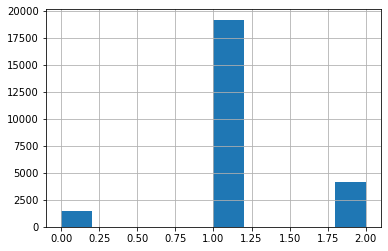

In [6]:
twitter_df = pd.read_csv('Davidson_data.csv')

# uncomment (and comment out above) if getting data from data file
#twitter_df = pd.read_csv('data/Davidson_data.csv')

twitter_df['class'].hist()

In [7]:
tweets=twitter_df.tweet
len(tweets)

24783

In [8]:
display(tweets[0:3])

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
Name: tweet, dtype: object

# Feature Generation for the Davidson et al. Twitter Dataset

# Part 1 - Preprocess, Tokenize and TF-IDF Vectorization

In [9]:
'''The original Davidson et al. Twitter classification code has been slightly modified to
better account for the inherent differences between Twitter and Reddit comments.'''

stemmer = PorterStemmer()

# list of stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))  # use this when stopwords included in tokenize
#stopwords = nltk.corpus.stopwords.words("english")
#tokens = [stemmer.stem(word) for word in stopwords] 


# used in vectorizer
def preprocess(text_string):     # used in vectorizer
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text


# used in vectorizer
def tokenize(tweet):              
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    
    # added in 
    
    '''ORIGINAL CODE UPDATED: A bug in the original code was updated here,
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip() was changed to
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()'''
    
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tweet = tweet.split()
    tweet_no_stopwprds = [word for word in tweet if not word in stopwords]
    tokens = [stemmer.stem(t) for t in tweet_no_stopwprds]     
    return tokens

# used in POS vectorizer
def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    
    '''ORIGINAL CODE UPDATED: A bug in the original code was updated here,
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip() was changed to
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()'''
    
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()


vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=1.0
    )

#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

# Part 2 - POS Tagging

In [10]:
'''The original Davidson et al. Twitter classification code has been slightly modified to
better account for the inherent differences between Twitter and Reddit comments.'''

#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
    
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=1.0
    )

#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

# Part 3 - Sentiment Analysis and Text & Readability Scores

In [11]:
'''The original Davidson et al. Twitter classification code has been slightly modified to
better account for the inherent differences between Twitter and Reddit comments.
example: retweets are not included as a feature
'''

#Finally we get sentiment analysis and other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    words = preprocess(tweet)
    
    # Text and Readability feature scores 
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
        
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0]]
    
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls"]

feats = get_feature_array(tweets)

In [12]:
#Now join them all up to create the final matrix
M = np.concatenate([tfidf,pos,feats],axis=1)
M.shape

# 24,783 comments; 11290 features

(24783, 11297)

In [13]:
'''These feature names are unnecessary for running the model but allow us to better 
visualize the features.'''

# Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the Model on the Davidson et al. Twitter Dataset

The Twitter hate speech detection model was selected by Davidson et al. used a logistic regression pipeline with an L1 penalty to select the best features and reduce dimensionality, and L2 regularization to predict the class label. They did, however, find that Logistic Regression and LinearSVC models performed similarly, and through testing we decided that a LinearSVC model results in a more accurate classification of our collected Reddit comments, so we chose this method. 

In [14]:
X = pd.DataFrame(M)
y = twitter_df['class'].astype(int)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.3)

In [15]:
# reduce dimensionality of the data

# solver chosen because default ('lbfgs') supports only l2 regularization

select = SelectFromModel(LogisticRegression(class_weight = 'balanced',
                                           C = 0.01, 
                                           penalty = 'l1',
                                           solver = 'liblinear',
                                           random_state = RANDOM_SEED))
X_ = select.fit_transform(X,y)

In [16]:
'''The Davidson et al. paper describes their final model as a LogisticRegression model, 
but their code identified as the final classifier did
include a LinearSVC model with the following parameters in their documentation.'''
# this model failed to converge even when max_iter was increased to 7500

"""
model = LinearSVC(class_weight = 'balanced',
                penalty = 'l2',
                loss='squared_hinge',
                C=0.01,
                multi_class='ovr',
                max_iter = 7500).fit(X_, y)

y_preds = model.predict(X_)

"""

"\nmodel = LinearSVC(class_weight = 'balanced',\n                penalty = 'l2',\n                loss='squared_hinge',\n                C=0.01,\n                multi_class='ovr',\n                max_iter = 7500).fit(X_, y)\n\ny_preds = model.predict(X_)\n\n"

In [17]:
# the paper describes a logistic regression model with l2 regularization 

# default solver is 'lbfgs'
# max_iter default is 100; included here so more iterations completed so model converges

model = LogisticRegression(class_weight = 'balanced',
                           C = 0.01, 
                           penalty = 'l2',
                           max_iter = 5000).fit(X_, y)

y_preds = model.predict(X_)


# Evaluating the Davidson et al. Twitter Classification Results

In [18]:
report = classification_report(y, y_preds)

In [19]:
print(report)

              precision    recall  f1-score   support

           0       0.30      0.77      0.43      1430
           1       0.98      0.83      0.90     19190
           2       0.82      0.95      0.88      4163

    accuracy                           0.85     24783
   macro avg       0.70      0.85      0.74     24783
weighted avg       0.91      0.85      0.87     24783



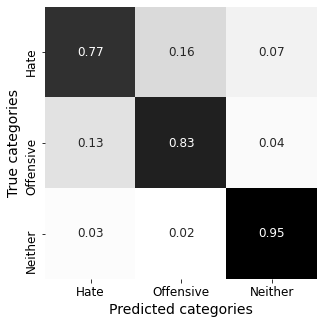

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

In their analysis, Davidson et al. write that, “far fewer tweets are classified as more 
offensive or hateful than their true category...suggesting that the model is biased towards 
classifying tweets as less hateful or offensive than the human coders.”

Note: these figures are considerably different than the figures in the paper (e.g., here hate-hate is 0.78 (0.40 in previous version), in the paper it is 0.61)

Text(0.5, 0, 'hate                                       offensive                         neither')

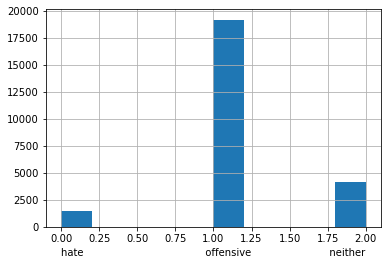

In [21]:
#True Davidson et al. Twitter distribution
y.hist()
plt.xlabel('hate                                       offensive                         neither', ha='center')

Text(0.5, 0, 'hate                                       offensive                         neither')

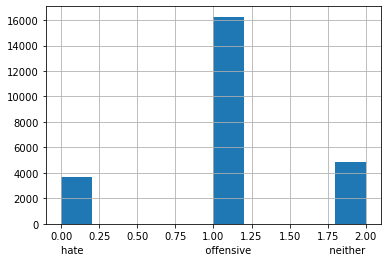

In [22]:
#Predicted Davidson et al. Twitter distribution
pd.Series(y_preds).hist()
plt.xlabel('hate                                       offensive                         neither', ha='center')

*** The slightly modified Davidson et al. Twitter Hate Speech Classification code ends here. ***
Modifications were  made so this code is consistent with the description in the paper 

In [23]:
hate_class_length = len(y_preds[np.all([y_preds == 0], axis = 0)])
offensive_class_length = len(y_preds[np.all([y_preds == 1], axis = 0)])
neither_class_length = len(y_preds[np.all([y_preds == 2], axis = 0)])

total = hate_class_length + offensive_class_length + neither_class_length

display('hate', hate_class_length)       # 3,708 for model w/o stopwords removed before stemming
display('offensive', offensive_class_length)  # 16,256
display('neither', neither_class_length)    # 4,819
display('total', total)

'hate'

3685

'offensive'

16265

'neither'

4833

'total'

24783

*** Our Reddit Submission Title Classification code begins here. ***

# Reddit titles
### Predict classes of the submission title
### hate (0), offensive (1), neither (2)
### note: 146,745 submissions out of 187,874 includes meaningful titles
### The submission title field could be empty, deleted, or removed. See the end of the notebook for an examination of the fields with only meaningful submissions.

In [24]:
# use this to work with the complete Reddit submission dataframe
# 'd_submissions_df.csv' is too large for github
submissions_df = pd.read_csv('d_submissions_df.csv')

#display(submissions_df.info())

# use code below to use a sample of the complete Reddit submission dataframe
### when the data is not at the same level as the classifier (it is in a data folder)

#submissions_df = pd.read_csv('data/d_submissions_df.csv')

# clean text in submissions_df
# 146745 non-null titles (of 187874)

submissions_df = submissions_df[['id', 'selftext', 'title']]
submissions_df = submissions_df.fillna('NaN no text')
submissions_df = submissions_df.replace({'':'no text'}).astype(str)
submissions_df = submissions_df.replace({'[deleted]':'deleted text'}).astype(str)
submissions_df = submissions_df.replace({'[removed]':'removed text'}).astype(str)
submissions_df = submissions_df.replace({'.':'period'}).astype(str)

submissions_title = submissions_df[['id', 'title']]
s_titles = submissions_title.title


In [25]:
'''This block of code takes a while to run, as it performs all three steps of feature
extraction.'''

# Using the same methods as above, we construct a tfidf matrix using the vectorizer 
# and get relevant scores.

#------------------------------------
# tokenize, tf-idf vectorization
#------------------------------------

# vectorizer is established above
# uses the functions tokenize (removes stopwords and stems) and preprocess (cleans text)

s_titles_tfidf = vectorizer.transform(s_titles).toarray()
s_titles_vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
s_titles_idf_vals = vectorizer.idf_
s_titles_idf_dict = {i:idf_vals[i] for i in s_titles_vocab.values()} #keys are indices; values are IDF scores

#------------------------------------
# POS tagging and POS tf matrix
# result: vocab dictionary
#------------------------------------

# Similarly we tokenize the comments to get the POS tags
# uses the function basic_tokenize (returns tokens)
s_titles_tags = []
for t in s_titles:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    s_titles_tags.append(tag_str)

# uses the pos_vectorizer (pos) trained on the Titter data

######***********************pos_vectorizer.fit(pd.Series(tweet_tags))
s_titles_pos = pos_vectorizer.transform(pd.Series(s_titles_tags)).toarray()
s_titles_pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

#------------------------------------
# Finally... sentiment and other features
#------------------------------------

s_titles_feats = get_feature_array(s_titles)


#------------------------------------
# data to use for modeling
#------------------------------------

# Join them up as above, and check to make sure each row is of the same length as in the
# Davidson et al. dataset so that the model will run
s_titles_M = np.concatenate([s_titles_tfidf, s_titles_pos, s_titles_feats],axis=1)
s_titles_M.shape   # same number  of features as twitter data


(187874, 11297)

In [26]:
'''Again, this is unnecessary for running the model but allows us to better visualize the
features.'''

#Finally get a list of variable names
s_titles_variables = ['']*len(s_titles_vocab)
for k,v in s_titles_vocab.items():
    s_titles_variables[v] = k

s_titles_pos_variables = ['']*len(s_titles_pos_vocab)
for k,v in s_titles_pos_vocab.items():
    s_titles_pos_variables[v] = k

s_titles_feature_names = s_titles_variables + s_titles_pos_variables + other_features_names
# submissions_feature_names

## Predict classifications for Reddit titles
### hate (0), offensive (1), neither (2)

In [27]:
s_titles_reduced = select.transform(s_titles_M)
display(s_titles_reduced.shape)                     # same # features as twitter data
s_titles_labels = model.predict(s_titles_reduced)

(187874, 177)

In [28]:
# Add the class labels into the original comments dataframe
submissions_df['title_label']  = s_titles_labels

## Examine the Reddit title classifications

Text(0.5, 0, 'hate                                       offensive                         neither')

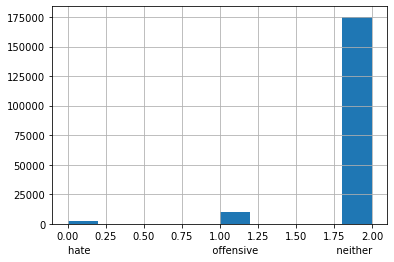

In [29]:
# Distribution of Reddit dataset

submissions_df['title_label'].hist()
plt.xlabel('hate                                       offensive                         neither', ha='center')

In [30]:
hate_class = submissions_df[submissions_df['title_label'] == 0]
hate_title = hate_class[['title', 'title_label']].sample(10)
pd.set_option('display.max_colwidth', 100)
hate_title = hate_title.style.set_properties(**{'text-align': 'left'})
display(hate_title)

,title,title_label
33382,"Fauci, the weasel-faced cunt, gets told that people don't like or trust him.",0
28173,Tell me what a useless ugly cunt she is,0
170744,I wish I could kill myself without it causing trauma for other people,0
181746,Dm me if u wanna fill this fat ass slut,0
176286,"Richard Spencer, ""White People are the Villains of History. CRT is Correct.""",0
49277,Tell me how ugly my cunt is,0
98459,[f4m] 22f Toronto Fucked up whore that has some stories to tell,0
95548,Evil mask defier kills his grandma 😠,0
134200,"Is a racist, racist?",0
80425,BGL and a fat dude shit on another fat dude whilst sat next to a fat dude.,0


In [31]:
offensive_class = submissions_df[submissions_df['title_label'] == 1]
offensive_title = offensive_class[['title', 'title_label']].sample(10)
pd.set_option('display.max_colwidth', 100)
offensive_title = offensive_title.style.set_properties(**{'text-align': 'left'})
display(offensive_title)

,title,title_label
89349,How the fuck was I rejected Purdue EA,1
40614,How in the FUCK do you report a porn website?,1
94574,Redhead gets her face covered in cum after her pussy is fucked,1
163906,I like to spread my ass so you can thrust deeper in me 😈😈,1
43324,Need a bully to fuck and degrade my mom Amanda,1
26827,Fucking her slutty face,1
185942,Been thinking about the next big dick I’m going to fuck all day like the slut I am.,1
168519,Would anyone breed my virgin pussy? [oc],1
143505,Fucking my ass with my tentacle always makes my cunt so wet. It feels so good stretching me out,1
176075,"Hey, it's u/femalegirl001 here, I swapped bodies with u/spacetime_hood by using a spell online and love being in her hot body. I need something inside me my new pussy maybe I'll see if my old body is interested",1


In [32]:
neither_class = submissions_df[submissions_df['title_label'] == 2]
neither_title = neither_class[['title', 'title_label']].sample(10)
pd.set_option('display.max_colwidth', 100)
neither_title = neither_title.style.set_properties(**{'text-align': 'left'})
display(neither_title)

,title,title_label
33395,NaN no text,2
33742,How are people dealing with someone who refuses to put on a mask while shopping in a store you work at??,2
114911,Any Fellows Trans Hunters in here?,2
140595,"Can I get a ""Wort Wort Wort"" up in here?",2
16692,Ashli Babbitt a Martyr? Her Past Tells a More Complex Story,2
117009,Unpopular opinion: Smoke breaks should be outright illegal!,2
90681,A comrade on me left and a comrade on me right,2
132287,Declined an interview request at amazon for $175K,2
85644,"""He takes that 5%."" When family can be embarrassing!",2
163988,Does anyone else follow a specific “theme” when naming their houseplants?,2


In [33]:
## examine classification of only titles that include meaningful text

In [34]:
trimmed_submissions_df = submissions_df[(submissions_df['title'] != 'NaN no text')\
                                        & (submissions_df['title'] != 'no text')\
                                        & (submissions_df['title'] != 'deleted text')\
                                        & (submissions_df['title'] != 'removed text')\
                                        & (submissions_df['title'] != 'period')]

Text(0.5, 0, 'hate                                       offensive                         neither')

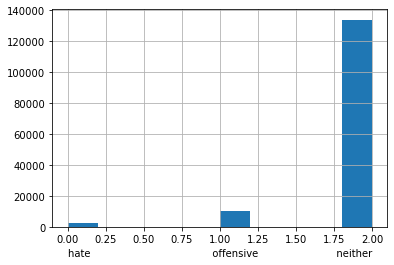

In [35]:
trimmed_submissions_df['title_label'].hist()
plt.xlabel('hate                                       offensive                         neither', ha='center')

In [36]:
## Write df with labels for submission title

In [37]:
'''Uncomment to create a CSV of the raw comments dataset with class labels.'''
submissions_df.to_csv('submissions_title_label.csv')
display(submissions_df.head())

,id,selftext,title,title_label
0,rsoja2,NaN no text,"women and arabs, ladies and gentlemen.",2
1,rsv9a0,I am a submissive girl and I have been sucking my friends since I’m 19. I have also used to be a...,I (26F) am a Muslim girl but I don’t mind being a free use to my friends,2
2,rst26k,NaN no text,Making bee candies,2
3,rsvx9y,👯hey SlutS! 👯💅 Now that we got our yearly 🎁 FUCK 👊🏼from good ole Saint DICK 🎅🏾 it’s FINALLY New ...,🎊Happy New Years SLUTS 🍆,2
4,rskw51,NaN no text,What are signs a guy hasn’t matured?,2


## combine submission selftext and submission title dfs into one submissions df

In [40]:
selftext_df = pd.read_csv('submissions_selftext_label.csv')
title_df = submissions_df
combined_df = selftext_df.merge(title_df)
display(combined_df.head())

# write final df
combined_df.to_csv('submissions_labels.csv')

,Unnamed: 0,id,selftext,title,selftext_label,title_label
0,0,rsoja2,NaN no text,"women and arabs, ladies and gentlemen.",2,2
1,1,rsv9a0,I am a submissive girl and I have been sucking my friends since I’m 19. I have also used to be a...,I (26F) am a Muslim girl but I don’t mind being a free use to my friends,2,2
2,2,rst26k,NaN no text,Making bee candies,2,2
3,3,rsvx9y,👯hey SlutS! 👯💅 Now that we got our yearly 🎁 FUCK 👊🏼from good ole Saint DICK 🎅🏾 it’s FINALLY New ...,🎊Happy New Years SLUTS 🍆,2,2
4,4,rskw51,NaN no text,What are signs a guy hasn’t matured?,2,2
